In [1]:
index=1
update = True

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152

os.environ["CUDA_VISIBLE_DEVICES"]='5'

from importlib.machinery import SourceFileLoader
import uproot as up
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
tf.get_logger().setLevel('INFO')

time1 = time.time()

sys.path.append('/software/pc24403/tfpcbpggsz/func')
sys.path.append('/software/pc24403/tfpcbpggsz/amp_ampgen_test')
sys.path.append('/software/pc24403/tfpcbpggsz/core')
from amp import *
from core_test_mine import *
from tfmassshape import *

mc_path = '/shared/scratch/pc24403/amp_ampgen'



def get_mass(p1,p2):
    return ((p1[:,0]+p2[:,0])**2 - (p1[:,1]+p2[:,1])**2 - (p1[:,2]+p2[:,2])**2 - (p1[:,3]+p2[:,3])**2)


def get_p4(decay="b2dpi", cut='', index=index):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_{index}.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_{index}.root:DalitzEventList'

    tree = up.open(file_name)
    charge = '_1_K0S0_E>0'
    if cut == 'p':
        charge = '(Bac_ID>0) & (B_M> 5150)& (tagmode==1)'
    if cut == 'm':
        charge = '(Bac_ID<0)& (B_M> 5150)& (tagmode==1)'
       
    array = tree.arrays(branch_names, charge)
    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))



    return p1, p2, p3, p1bar, p2bar, p3bar

def load_int_amp(args):
    p1, p2, p3 = args

    return Kspipi.AMP(p1.tolist(), p2.tolist(), p3.tolist())

def getAmp(decay='b2dpi', cut='int', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    data = [(p1_np[i], p2_np[i], p3_np[i]) for i in range(len(p1_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitude.append(pool.map(load_int_amp, data))
    data_bar = [(p1bar_np[i], p3bar_np[i], p2bar_np[i]) for i in range(len(p1bar_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitudeBar.append(pool.map(load_int_amp, data_bar))
    
    end_time = time.time()
    print(f'Amplitude for {decay} loaded in {end_time-start_time} seconds')
    amplitude = np.array(amplitude)
    amplitudeBar = np.negative(np.array(amplitudeBar))

    return amplitude, amplitudeBar
    
def get_p4_v2(decay="b2dpi", cut='', index=index, comp='sig'):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_{index}.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_{index}.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    charge = '(Bac_ID>0)& (B_M> 5150) & (tagmode==1)'
    if cut == 'm':
        charge = '(Bac_ID<0)& (B_M> 5150)& (tagmode==1)'
    
    array = tree.arrays(branch_names, charge)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))

    B_M = np.zeros(len(p1))
    if cut != 'int':
        
        B_M = np.asarray([array["B_M"]])


    return p1, p2, p3, p1bar, p2bar, p3bar, B_M


def getMass(decay='b2dpi', cut='int', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13

def getMass_v2(decay='b2dpi', cut='int', comp='sig', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp=comp, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13, B_M



def scanner(m, scan_range=1, size=50):
    pts = {}
    for i in range(0, 6):
        for j in range(i + 1, 6):
            a = m.parameters[i]
            b = m.parameters[j]
            a_err = m.errors[i]
            b_err = m.errors[j]
            a_val = m.values[i]
            b_val = m.values[j]
            x0, x1 = i, j  # Assign x0 and x1 for key naming
            pts[f"{x0}_{x1}"] = m.contour(
                a, b,
                bound=[
                    [a_val - scan_range * a_err, a_val + scan_range * a_err],
                    [b_val - scan_range * b_err, b_val + scan_range * b_err]
                ],
                size=size
            )
    return pts


config_mass_shape_output = SourceFileLoader('config_mass_shape_output', '/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/config/lhcb/1x/%s'%(f'config_cpfit_output_{index}.py')).load_module()

varDict = config_mass_shape_output.getconfig()
print_yields = True
sig_yield = {}
Bdecays = ['b2dk']#, 'b2dpi']
Types = ['LL', 'DD']
for bdecay in Bdecays:
    for Type in Types:
        decay = ''

        if bdecay == 'b2dk':
            decay = 'DK_KsPiPi_%s'%Type
        elif bdecay == 'b2dpi':
            decay = 'DPi_KsPiPi_%s'%Type

        #print yields
        if print_yields == True:
            print('Yields:')
            print('Sig: %.2f'%varDict['n_sig_%s'%decay])
            print('MisID: %.2f'%varDict['n_misid_%s'%decay])
            print('Low: %.2f'%varDict['n_low_%s'%decay])
            print('Comb: %.2f'%varDict['n_comb_%s'%decay])
            if bdecay == 'b2dk':
                print('Low MisID: %.2f'%varDict['n_low_misID_%s'%decay])
                print('Low Bs2DKPi: %.2f'%varDict['n_low_Bs2DKPi_%s'%decay])
                sum_yields = varDict['n_sig_%s'%decay] + varDict['n_misid_%s'%decay] + varDict['n_low_%s'%decay] + varDict['n_comb_%s'%decay] + varDict['n_low_misID_%s'%decay] + varDict['n_low_Bs2DKPi_%s'%decay]
            else:
                sum_yields = varDict['n_sig_%s'%decay] + varDict['n_misid_%s'%decay] + varDict['n_low_%s'%decay] + varDict['n_comb_%s'%decay]
            print('Sum: %.2f'%sum_yields)



pdfs_data = {}
s12_data = {}
s13_data = {}
Bu_M = {}
mass_pdfs = {}
pdfs_mc = {}
s12_mc = {}
s13_mc = {}
Bu_M_mc = {}

for decay in ['b2dk_LL', 'b2dk_DD']:#, 'b2dpi_LL', 'b2dpi_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        print('--- INFO: Preparing pdfs for %s...'%new_decay)
        s12_mc[new_decay], s13_mc[new_decay] = getMass(new_decay, 'int')
        Bu_M_mc[new_decay] = np.linspace(5150, 5800, s12_mc[new_decay].shape[0])
        pdfs_mc[new_decay] = preparePdf_data(Bu_M_mc[new_decay], varDict, decay)
        s12_data[new_decay], s13_data[new_decay], Bu_M[new_decay] = getMass_v2(decay, charge, index)
        Bu_M[new_decay] = tf.cast(Bu_M[new_decay], tf.float64)

comps = ['sig', 'misid', 'comb', 'low', 'low_misID', 'low_Bs2DKPi']
for decay in ['b2dk_LL', 'b2dk_DD']:#, 'b2dpi_LL', 'b2dpi_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        mass_pdfs[new_decay] = {}
        for comp in comps:
            if decay.split('_')[0] == 'b2dpi' and (comp == 'low_Bs2DKPi' or comp == 'low_misID'): continue
            mass_pdfs[new_decay][comp] = pdfs_mc[new_decay][comp](Bu_M_mc[new_decay])
time2 = time.time()
        
print('INFO: mass Function loaded...')

if update == True:
    print('INFO: Updating Log...')
    comp_tag = {'sig': 1, 'comb': 2, 'misid': 3, 'low': 4, 'low_misid': 5, 'low_Bs2DKPi': 6}
    for decay in ['DK_KsPiPi_LL', 'DK_KsPiPi_DD', 'DPi_KsPiPi_LL', 'DPi_KsPiPi_DD']:
        new_decay = decay
        if decay.split('_')[0] == 'DK':
            new_decay = 'b2dk_'+decay.split('_')[2]
        elif decay.split('_')[0] == 'DPi':
            new_decay = 'b2dpi_'+decay.split('_')[2]
        file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{new_decay}_{index}.root:DalitzEventList'
        tree = up.open(file_name)
        for comp in comp_tag:
            array = tree.arrays('tagmode','(B_M>5150) & (tagmode==1) & (tagmode==%d)'%comp_tag[comp])
            varDict[f'n_{comp}_{decay}'] = len(array)
            print(f'n_{comp}_{decay} = {len(array)} . {comp_tag[comp]}')
            





logpath = '/dice/users/pc24403/BPGGSZ/sim_fit_check_each'
if os.path.exists(logpath) == False:
    os.mkdir(logpath)


print('INFO: Initialize the amplitudes...')

amp_Data__dk_dd_m = []
ampbar_Data_dk_dd_m = []
amp_Data_dk_dd_p = []
ampbar_Data_dk_dd_p = []
amp_Data_dk_ll_m = []
ampbar_Data_dk_ll_m = []
amp_Data_dk_ll_p = []
ampbar_Data_dk_ll_p = []
amp_dk_ll_p = []
amp_dk_ll_m = []
amp_dk_dd_p = []
amp_dk_dd_m = []
ampbar_dk_ll_p = []
ampbar_dk_ll_m = []
ampbar_dk_dd_p = []
ampbar_dk_dd_m = []

amp_Data_dpi_dd_m = []
ampbar_Data_dpi_dd_m = []
amp_Data_dpi_dd_p = []
ampbar_Data_dpi_dd_p = []
amp_Data_dpi_ll_m = []
ampbar_Data_dpi_ll_m = []
amp_Data_dpi_ll_p = []
ampbar_Data_dpi_ll_p = []
amp_dpi_ll_p = []
amp_dpi_ll_m = []
amp_dpi_dd_p = []
amp_dpi_dd_m = []
ampbar_dpi_ll_p = []
ampbar_dpi_ll_m = []
ampbar_dpi_dd_p = []
ampbar_dpi_dd_m = []


print('INFO: Loading amplitudes...')


amp_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_amp.npy')
ampbar_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_ampbar.npy')
amp_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_amp.npy')
ampbar_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_ampbar.npy')
amp_dk_ll_p = np.load(mc_path + '/Int_b2dk_LL_p_amp.npy')
ampbar_dk_ll_p = np.load(mc_path + '/Int_b2dk_LL_p_ampbar.npy')
amp_dk_ll_m = np.load(mc_path + '/Int_b2dk_LL_m_amp.npy')
ampbar_dk_ll_m = np.load(mc_path + '/Int_b2dk_LL_m_ampbar.npy')


amp_dpi_dd_p = np.load(mc_path + '/Int_b2dpi_DD_p_amp.npy')
ampbar_dpi_dd_p = np.load(mc_path + '/Int_b2dpi_DD_p_ampbar.npy')
amp_dpi_dd_m = np.load(mc_path + '/Int_b2dpi_DD_m_amp.npy')
ampbar_dpi_dd_m = np.load(mc_path + '/Int_b2dpi_DD_m_ampbar.npy')
amp_dpi_ll_p = np.load(mc_path + '/Int_b2dpi_LL_p_amp.npy')
ampbar_dpi_ll_p = np.load(mc_path + '/Int_b2dpi_LL_p_ampbar.npy')
amp_dpi_ll_m = np.load(mc_path + '/Int_b2dpi_LL_m_amp.npy')
ampbar_dpi_ll_m = np.load(mc_path + '/Int_b2dpi_LL_m_ampbar.npy')

'''
amp_Data_dk_dd_p, ampbar_Data_dk_dd_p = getAmp('b2dk_DD', 'p', index=index)
amp_Data_dk_dd_m, ampbar_Data_dk_dd_m = getAmp('b2dk_DD', 'm', index=index)
amp_Data_dk_ll_p, ampbar_Data_dk_ll_p = getAmp('b2dk_LL', 'p', index=index)
amp_Data_dk_ll_m, ampbar_Data_dk_ll_m = getAmp('b2dk_LL', 'm', index=index)
amp_Data_dpi_dd_p, ampbar_Data_dpi_dd_p = getAmp('b2dpi_DD', 'p', index=index)
amp_Data_dpi_dd_m, ampbar_Data_dpi_dd_m = getAmp('b2dpi_DD', 'm', index=index)
amp_Data_dpi_ll_p, ampbar_Data_dpi_ll_p = getAmp('b2dpi_LL', 'p', index=index)
amp_Data_dpi_ll_m, ampbar_Data_dpi_ll_m = getAmp('b2dpi_LL', 'm', index=index)
#Post to TF constant
amp_Data_dk_dd_p = tf.constant(amp_Data_dk_dd_p, dtype=tf.complex128)
ampbar_Data_dk_dd_p = tf.constant(ampbar_Data_dk_dd_p, dtype=tf.complex128)
amp_Data_dk_dd_m = tf.constant(amp_Data_dk_dd_m, dtype=tf.complex128)
ampbar_Data_dk_dd_m = tf.constant(ampbar_Data_dk_dd_m, dtype=tf.complex128)
amp_Data_dk_ll_p = tf.constant(amp_Data_dk_ll_p, dtype=tf.complex128)
ampbar_Data_dk_ll_p = tf.constant(ampbar_Data_dk_ll_p, dtype=tf.complex128)
amp_Data_dk_ll_m = tf.constant(amp_Data_dk_ll_m, dtype=tf.complex128)
ampbar_Data_dk_ll_m = tf.constant(ampbar_Data_dk_ll_m, dtype=tf.complex128)
'''
amp_dk_dd_p = tf.constant(amp_dk_dd_p, dtype=tf.complex128)
ampbar_dk_dd_p = tf.constant(ampbar_dk_dd_p, dtype=tf.complex128)
amp_dk_dd_m = tf.constant(amp_dk_dd_m, dtype=tf.complex128)
ampbar_dk_dd_m = tf.constant(ampbar_dk_dd_m, dtype=tf.complex128)
amp_dk_ll_p = tf.constant(amp_dk_ll_p, dtype=tf.complex128)
ampbar_dk_ll_p = tf.constant(ampbar_dk_ll_p, dtype=tf.complex128)
amp_dk_ll_m = tf.constant(amp_dk_ll_m, dtype=tf.complex128)
ampbar_dk_ll_m = tf.constant(ampbar_dk_ll_m, dtype=tf.complex128)
amp_dpi_dd_p = tf.constant(amp_dpi_dd_p, dtype=tf.complex128)
ampbar_dpi_dd_p = tf.constant(ampbar_dpi_dd_p, dtype=tf.complex128)
amp_dpi_dd_m = tf.constant(amp_dpi_dd_m, dtype=tf.complex128)
ampbar_dpi_dd_m = tf.constant(ampbar_dpi_dd_m, dtype=tf.complex128)
amp_dpi_ll_p = tf.constant(amp_dpi_ll_p, dtype=tf.complex128)
ampbar_dpi_ll_p = tf.constant(ampbar_dpi_ll_p, dtype=tf.complex128)
amp_dpi_ll_m = tf.constant(amp_dpi_ll_m, dtype=tf.complex128)
ampbar_dpi_ll_m = tf.constant(ampbar_dpi_ll_m, dtype=tf.complex128)

time3 = time.time()


def prod_nll_dk_dd(x, Bsign=1):

    decay = 'b2dk_DD'
    fracDD = 0.53

    nsig = x[6]*0.5
    nmisid = varDict['n_misid_DK_KsPiPi_DD']*0.5
    ncomb = x[7]*0.5
    nlow = x[8]*0.5
    nlow_misID = varDict['n_low_misID_DK_KsPiPi_DD']*0.5
    nlow_Bs2DKPi = varDict['n_low_Bs2DKPi_DK_KsPiPi_DD']*0.5



    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_p, ampbar_dpi_dd_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_m, ampbar_dpi_dd_m)

    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_m)**2)

    sig_prob_p = nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_XY(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_XY(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_p = nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_dk_dd_p, ampbar_dk_dd_p, misid_normA_m, misid_normAbar_p, fracDD=fracDD)
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_dk_dd_m, ampbar_dk_dd_m, misid_normA_m, misid_normAbar_p, fracDD=fracDD)
    low_prob_p = nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')
    low_misID_prob_p =  nlow_misID * mass_pdfs[decay+'_p']['low_misID'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_misID')
    low_misID_prob_m =  nlow_misID * mass_pdfs[decay+'_m']['low_misID'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_misID')
    low_Bs2DKPi_prob_p = nlow_Bs2DKPi * mass_pdfs[decay+'_p']['low_Bs2DKPi'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_Bs2DKPi')
    low_Bs2DKPi_prob_m = nlow_Bs2DKPi * mass_pdfs[decay+'_m']['low_Bs2DKPi'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_Bs2DKPi')



    total_yield = (nsig + nmisid + ncomb + nlow + nlow_misID + nlow_Bs2DKPi)*2
    
    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 


    low_normalisation_Bplus = tf.cast(misid_normAbar_p, tf.float64)
    low_normalisation_Bminus = tf.cast(misid_normA_m, tf.float64)


    prob_p = {}
    prob_m = {}
    prob_p['total'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)+(misid_prob_p/misid_normalisation_Bplus)+(comb_prob_p)+(low_prob_p/low_normalisation_Bplus)+(low_misID_prob_p/low_normalisation_Bplus)+(low_Bs2DKPi_prob_p/low_normalisation_Bplus)))
    prob_m['total'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)+(misid_prob_m/misid_normalisation_Bminus)+(comb_prob_m)+(low_prob_m/low_normalisation_Bminus)+(low_misID_prob_m/low_normalisation_Bminus)+(low_Bs2DKPi_prob_m/low_normalisation_Bminus)))
    prob_p['sig'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)))
    prob_m['sig'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)))
    prob_p['misid'] = (1/total_yield*((misid_prob_p/misid_normalisation_Bplus)))
    prob_m['misid'] = (1/total_yield*((misid_prob_m/misid_normalisation_Bminus)))
    prob_p['comb'] = (1/total_yield*((comb_prob_p)))
    prob_m['comb'] = (1/total_yield*((comb_prob_m)))
    prob_p['low'] = (1/total_yield*((low_prob_p/low_normalisation_Bplus)))
    prob_m['low'] = (1/total_yield*((low_prob_m/low_normalisation_Bminus)))
    prob_p['low_misID'] = (1/total_yield*((low_misID_prob_p/low_normalisation_Bplus)))
    prob_m['low_misID'] = (1/total_yield*((low_misID_prob_m/low_normalisation_Bminus)))
    prob_p['low_Bs2DKPi'] = (1/total_yield*((low_Bs2DKPi_prob_p/low_normalisation_Bplus)))
    prob_m['low_Bs2DKPi'] = (1/total_yield*((low_Bs2DKPi_prob_m/low_normalisation_Bminus)))
                            
    if Bsign ==1:
        return prob_p
    else:
        return prob_m



def prod_nll_dk_ll(x, Bsign=1):

    decay = 'b2dk_LL'
    fracDD = 0.86


    nsig = x[6]*0.5
    nmisid = varDict['n_misid_DK_KsPiPi_LL']*0.5
    ncomb = x[7]*0.5
    nlow = x[8]*0.5
    nlow_misID = varDict['n_low_misID_DK_KsPiPi_LL']*0.5
    nlow_Bs2DKPi = varDict['n_low_Bs2DKPi_DK_KsPiPi_LL']*0.5

    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_ll_p, ampbar_dk_ll_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_ll_m, ampbar_dk_ll_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_ll_p, ampbar_dpi_ll_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_ll_m, ampbar_dpi_ll_m)
    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_ll_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_ll_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_ll_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_ll_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_ll_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_ll_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_ll_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_ll_m)**2)


    sig_prob_p = nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_XY(1, amp_dk_ll_p, ampbar_dk_ll_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_XY(-1, amp_dk_ll_m, ampbar_dk_ll_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_p = nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_dk_ll_p, ampbar_dk_ll_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_dk_ll_m, ampbar_dk_ll_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_dk_ll_p, ampbar_dk_ll_p, misid_normA_m, misid_normAbar_p, fracDD=fracDD)
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_dk_ll_m, ampbar_dk_ll_m, misid_normA_m, misid_normAbar_p, fracDD=fracDD)
    low_prob_p = nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_dk_ll_p, ampbar_dk_ll_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_dk_ll_m, ampbar_dk_ll_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')
    low_misID_prob_p =  nlow_misID * mass_pdfs[decay+'_p']['low_misID'] * prod_low(1, amp_dk_ll_p, ampbar_dk_ll_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_misID')
    low_misID_prob_m =  nlow_misID * mass_pdfs[decay+'_m']['low_misID'] * prod_low(-1, amp_dk_ll_m, ampbar_dk_ll_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_misID')
    low_Bs2DKPi_prob_p = nlow_Bs2DKPi * mass_pdfs[decay+'_p']['low_Bs2DKPi'] * prod_low(1, amp_dk_ll_p, ampbar_dk_ll_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_Bs2DKPi')
    low_Bs2DKPi_prob_m = nlow_Bs2DKPi * mass_pdfs[decay+'_m']['low_Bs2DKPi'] * prod_low(-1, amp_dk_ll_m, ampbar_dk_ll_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_Bs2DKPi')



    total_yield = (nsig + nmisid + ncomb + nlow + nlow_misID + nlow_Bs2DKPi)*2

    
    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 

    low_normalisation_Bplus = tf.cast(misid_normAbar_p, tf.float64)
    low_normalisation_Bminus = tf.cast(misid_normA_m, tf.float64)


    prob_p = {}
    prob_m = {}
    prob_p['total'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)+(misid_prob_p/misid_normalisation_Bplus)+(comb_prob_p)+(low_prob_p/low_normalisation_Bplus)+(low_misID_prob_p/low_normalisation_Bplus)+(low_Bs2DKPi_prob_p/low_normalisation_Bplus)))
    prob_m['total'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)+(misid_prob_m/misid_normalisation_Bminus)+(comb_prob_m)+(low_prob_m/low_normalisation_Bminus)+(low_misID_prob_m/low_normalisation_Bminus)+(low_Bs2DKPi_prob_m/low_normalisation_Bminus)))
    prob_p['sig'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)))
    prob_m['sig'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)))
    prob_p['misid'] = (1/total_yield*((misid_prob_p/misid_normalisation_Bplus)))
    prob_m['misid'] = (1/total_yield*((misid_prob_m/misid_normalisation_Bminus)))
    prob_p['comb'] = (1/total_yield*((comb_prob_p)))
    prob_m['comb'] = (1/total_yield*((comb_prob_m)))
    prob_p['low'] = (1/total_yield*((low_prob_p/low_normalisation_Bplus)))
    prob_m['low'] = (1/total_yield*((low_prob_m/low_normalisation_Bminus)))
    prob_p['low_misID'] = (1/total_yield*((low_misID_prob_p/low_normalisation_Bplus)))
    prob_m['low_misID'] = (1/total_yield*((low_misID_prob_m/low_normalisation_Bminus)))
    prob_p['low_Bs2DKPi'] = (1/total_yield*((low_Bs2DKPi_prob_p/low_normalisation_Bplus)))
    prob_m['low_Bs2DKPi'] = (1/total_yield*((low_Bs2DKPi_prob_m/low_normalisation_Bminus)))
                            
    if Bsign ==1:
        return prob_p
    else:
        return prob_m

def prod_nll_dpi_dd(x, Bsign):

    decay = 'b2dpi_DD'
    fracDD = 0.27

    nsig = x[9] * 0.5
    nmisid = varDict['n_misid_DPi_KsPiPi_DD']*0.5
    ncomb = x[10] * 0.5 
    nlow = x[11] * 0.5

    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_p, ampbar_dpi_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_m, ampbar_dpi_dd_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)

    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)


    sig_prob_p = nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_dpi_dd_p, ampbar_dpi_dd_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_dpi_dd_m, ampbar_dpi_dd_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])

    misid_prob_p = nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_XY(1, amp_dpi_dd_p, ampbar_dpi_dd_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_XY(-1, amp_dpi_dd_m, ampbar_dpi_dd_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_dpi_dd_p, ampbar_dpi_dd_p, normA_m, normAbar_p, fracDD=fracDD)
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_dpi_dd_m, ampbar_dpi_dd_m, normA_m, normAbar_p, fracDD=fracDD)
    low_prob_p = nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_dpi_dd_p, ampbar_dpi_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_dpi_dd_m, ampbar_dpi_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')

    total_yield = (nsig + nmisid + ncomb + nlow)*2.0
    
    normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 
    

    low_normalisation_Bplus = tf.cast(normAbar_p, tf.float64)
    low_normalisation_Bminus = tf.cast(normA_m, tf.float64)


    prob_p = {}
    prob_m = {}
    prob_p['total'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)+(misid_prob_p/misid_normalisation_Bplus)+(comb_prob_p)+(low_prob_p/low_normalisation_Bplus)))
    prob_m['total'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)+(misid_prob_m/misid_normalisation_Bminus)+(comb_prob_m)+(low_prob_m/low_normalisation_Bminus)))
    prob_p['sig'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)))
    prob_m['sig'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)))
    prob_p['misid'] = (1/total_yield*((misid_prob_p/misid_normalisation_Bplus)))
    prob_m['misid'] = (1/total_yield*((misid_prob_m/misid_normalisation_Bminus)))
    prob_p['comb'] = (1/total_yield*((comb_prob_p)))
    prob_m['comb'] = (1/total_yield*((comb_prob_m)))
    prob_p['low'] = (1/total_yield*((low_prob_p/low_normalisation_Bplus)))
    prob_m['low'] = (1/total_yield*((low_prob_m/low_normalisation_Bminus)))
                            
    if Bsign ==1:
        return prob_p
    else:
        return prob_m

def prod_nll_dpi_ll(x, Bsign=1):

    decay = 'b2dpi_LL'
    fracDD = 0.48

    nsig = x[9] * 0.5
    nmisid = varDict['n_misid_DPi_KsPiPi_LL']*0.5
    ncomb = x[10] * 0.5 
    nlow = x[11] * 0.5

    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_ll_p, ampbar_dpi_ll_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_ll_m, ampbar_dpi_ll_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_ll_p, ampbar_dk_ll_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_ll_m, ampbar_dk_ll_m)

    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_ll_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_ll_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_ll_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_ll_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)


    sig_prob_p = nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_dpi_ll_p, ampbar_dpi_ll_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_dpi_ll_m, ampbar_dpi_ll_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])

    misid_prob_p = nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_XY(1, amp_dpi_ll_p, ampbar_dpi_ll_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_XY(-1, amp_dpi_ll_m, ampbar_dpi_ll_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_dpi_ll_p, ampbar_dpi_ll_p, normA_m, normAbar_p, fracDD=fracDD)
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_dpi_ll_m, ampbar_dpi_ll_m, normA_m, normAbar_p, fracDD=fracDD)
    low_prob_p = nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_dpi_ll_p, ampbar_dpi_ll_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_dpi_ll_m, ampbar_dpi_ll_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')

    total_yield = (nsig + nmisid + ncomb + nlow)*2.0
    
    normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 

    


    low_normalisation_Bplus = tf.cast(normAbar_p, tf.float64)
    low_normalisation_Bminus = tf.cast(normA_m, tf.float64)



    prob_p = {}
    prob_m = {}
    prob_p['total'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)+(misid_prob_p/misid_normalisation_Bplus)+(comb_prob_p)+(low_prob_p/low_normalisation_Bplus)))
    prob_m['total'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)+(misid_prob_m/misid_normalisation_Bminus)+(comb_prob_m)+(low_prob_m/low_normalisation_Bminus)))
    prob_p['sig'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)))
    prob_m['sig'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)))
    prob_p['misid'] = (1/total_yield*((misid_prob_p/misid_normalisation_Bplus)))
    prob_m['misid'] = (1/total_yield*((misid_prob_m/misid_normalisation_Bminus)))
    prob_p['comb'] = (1/total_yield*((comb_prob_p)))
    prob_m['comb'] = (1/total_yield*((comb_prob_m)))
    prob_p['low'] = (1/total_yield*((low_prob_p/low_normalisation_Bplus)))
    prob_m['low'] = (1/total_yield*((low_prob_m/low_normalisation_Bminus)))
                            
    if Bsign ==1:
        return prob_p
    else:
        return prob_m





x = [-0.07178453554182719, 0.012320903698337849, 0.05701241875359355, 0.0599331555049205, -0.06638324964580493, -0.009647262490640452, varDict['n_sig_DK_KsPiPi_DD'], varDict['n_comb_DK_KsPiPi_DD'], varDict['n_low_DK_KsPiPi_DD'],  varDict['n_sig_DPi_KsPiPi_DD'],  varDict['n_comb_DPi_KsPiPi_DD'], varDict['n_low_DPi_KsPiPi_DD'],  varDict['n_sig_DK_KsPiPi_LL'],  varDict['n_comb_DK_KsPiPi_LL'], varDict['n_low_DK_KsPiPi_LL'],  varDict['n_sig_DPi_KsPiPi_LL'], varDict['n_comb_DPi_KsPiPi_LL'], varDict['n_low_DPi_KsPiPi_LL']]
x1 = x[:12]
x2 = np.concatenate([x[:6], x[12:18]])
prob_dpi_ll_p = prod_nll_dpi_ll(x2, 1)
prob_dpi_ll_m = prod_nll_dpi_ll(x2, -1)
prob_dpi_dd_p = prod_nll_dpi_dd(x1, 1)
prob_dpi_dd_m = prod_nll_dpi_dd(x1, -1)


'''
prob_dk_dd_p = prod_nll_dk_dd(x1, 1)
prob_dk_dd_m = prod_nll_dk_dd(x1, -1)
prob_dk_ll_p = prod_nll_dk_ll(x2, 1)
prob_dk_ll_m = prod_nll_dk_ll(x2, -1)
'''




2024-06-06 16:44:07.359415: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 16:44:07.432044: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 16:44:08.862759: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


D0ToKSpipi2018 (Apr 30 2024) ==> Initialization !


2024-06-06 16:44:10.489827: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Yields:
Sig: 4788.52
MisID: 1837.17
Low: 96.08
Comb: 1351.09
Low MisID: 1084.63
Low Bs2DKPi: 228.19
Sum: 9385.68
Yields:
Sig: 10805.91
MisID: 4018.86
Low: 37.95
Comb: 2987.20
Low MisID: 2519.50
Low Bs2DKPi: 643.09
Sum: 21012.52
--- INFO: Preparing pdfs for b2dk_LL_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dk_LL_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dk_DD_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dk_DD_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO:

KeyError: 'b2dpi_LL_p'

In [ ]:
import ROOT as rt
def plotOn(data=[], var=[], decay='b2dk_ll_p', weights=[], range=[5150, 5800]):
    hist = rt.TH1F('h', 'h', 100, range[0], range[1])
    for i in range(data.shape[0]):
        hist.Fill(data[i])
    hist.Draw("EP")
    hist.SetMarkerStyle(20)
    hist.SetMarkerSize(0.5)
    hist.SetMarkerColor(rt.kBlack)
    hist.SetLineColor(rt.kBlack)
    hist.GetXaxis().SetTitle('M(B^{+})')
    hist.GetYaxis().SetTitle('Entries')
    hist.GetYaxis().SetTitleOffset(1.5)
    hist.GetXaxis().SetTitleOffset(1.5)

    colors = ['kRed', 'kBlue', 'kGreen', 'kYellow', 'kViolet', 'kPink', 'kSilver']
    
    hist_i=[]
    for key in weights.keys():
        hist = rt.TH1F('h', 'h', 100, range[0], range[1])
        for i in range(var[decay].shape[0]):
            hist.Fill(var[decay][i], weights[key][i])
        hist_i.append(hist)
    
    for i, hist in enumerate(hist_i):
        hist.Draw("H same")
        hist.SetMarkerStyle(20)
        hist.SetMarkerSize(0.5)
        hist.SetMarkerColor(rt.TColor.GetColor(colors[i]))
        hist.SetLineColor(rt.TColor.GetColor(colors[i]))
        hist.SetLineWidth(2)




def plot_each(decay='b2dk_DD_p', prob={}):


    canvas = rt.TCanvas('c', 'c', 800*2, 600*2)
    canvas.Divide(2,2)
    canvas.cd(1)
    h = rt.TH2F('h', 'h', 100, 0.3, 3.2, 100, 0.3, 3.2)
    for i in range(s12_data[decay].shape[0]):
        h.Fill(s12_data[decay][i], s13_data[decay][i])

    h.Draw('colz')
    canvas.cd(2)
    h2 = rt.TH1F('h2', 'h2', 100, 5150, 5800)
    for i in range(Bu_M[decay].shape[0]):
        h2.Fill(Bu_M[decay][i])
    h2.Draw()


    plotOn(data=Bu_M[decay], var=Bu_M_mc[decay], decay=decay, weights=prob,  range=[5150, 5800], tag=0)
    plotOn(data=s12_data[decay], var=s12_mc[decay], decay=decay, weights=prob, range=[0.3, 3.2])
    plotOn(data=s13_data[decay], var=s13_mc[decay], decay=decay, weights=prob, range=[0.3, 3.2])

    plt.show()
    os.makedirs('plots', exist_ok=True)
    plt.savefig(f'plots/{decay}.png')


8.738548193727379
8.738548193727379
8.738548193727379


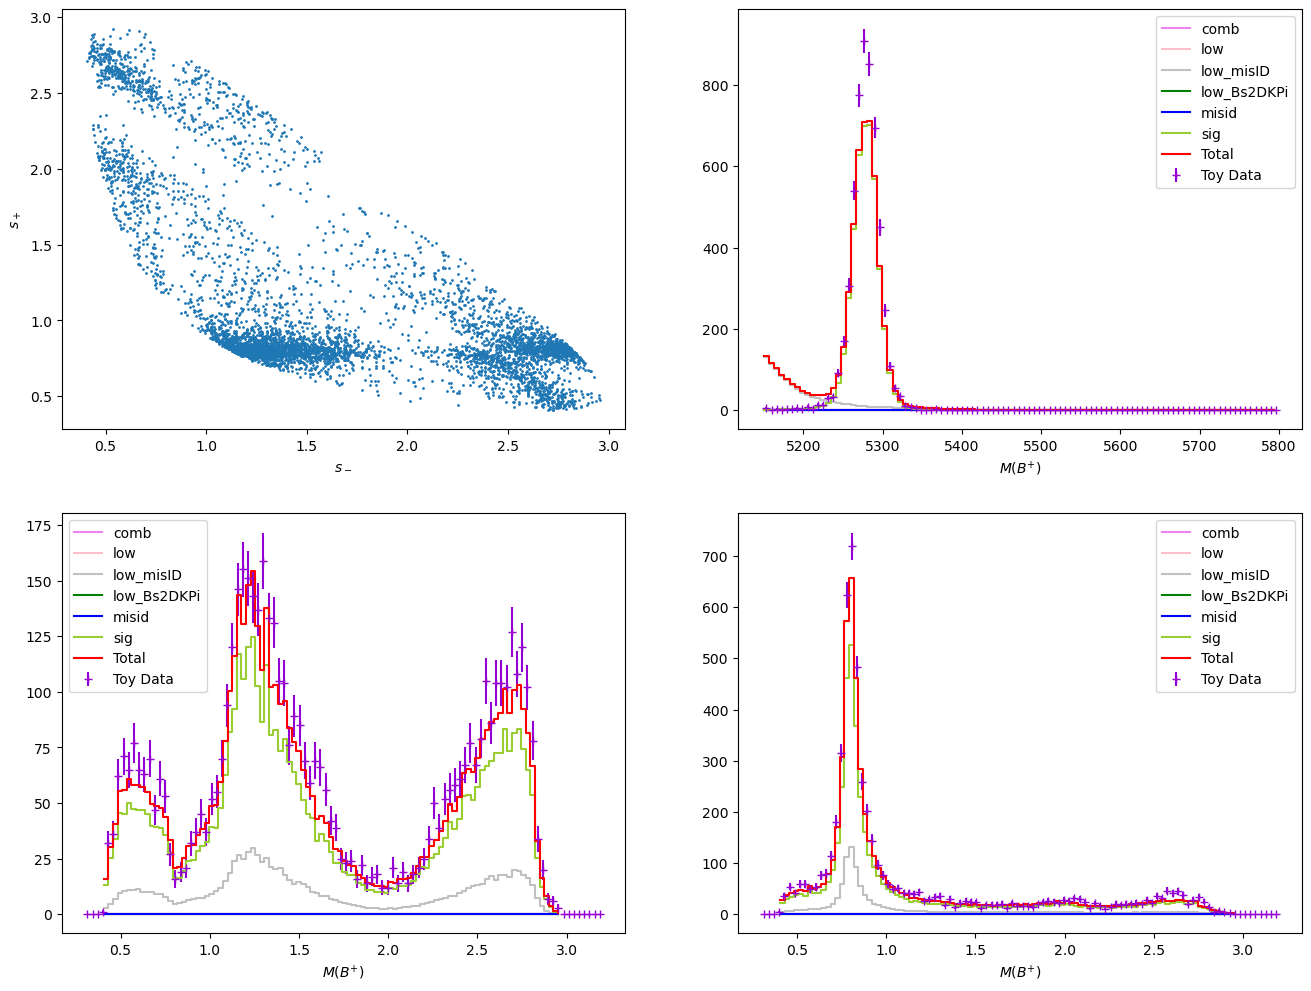

8.739546764764773
8.739546764764773
8.739546764764773


<Figure size 640x480 with 0 Axes>

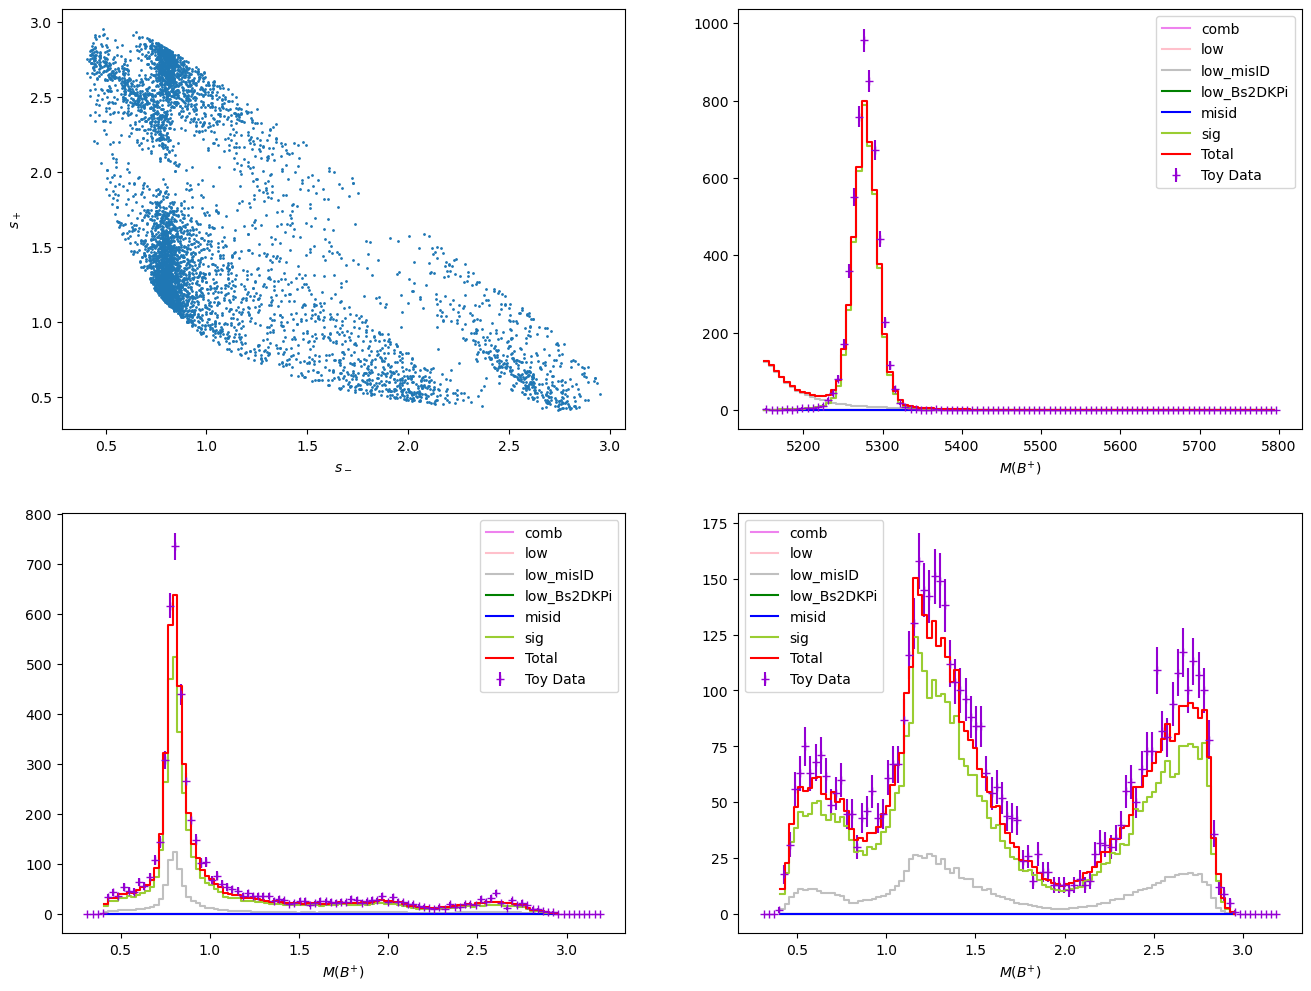

3.8654971671459135
3.8654971671459135
3.8654971671459135


<Figure size 640x480 with 0 Axes>

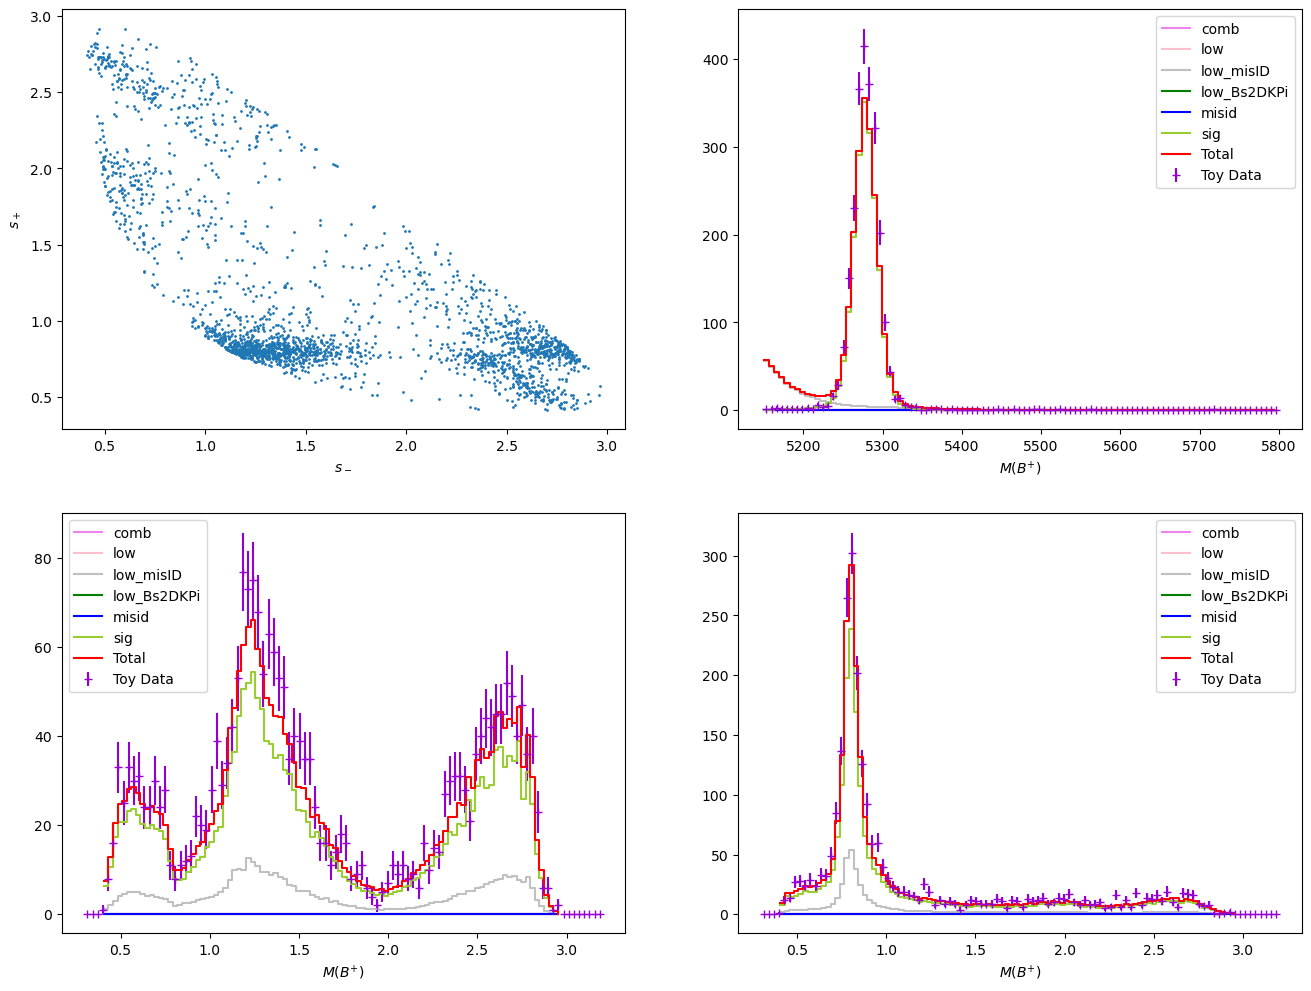

3.870601768967457
3.870601768967457
3.870601768967457


<Figure size 640x480 with 0 Axes>

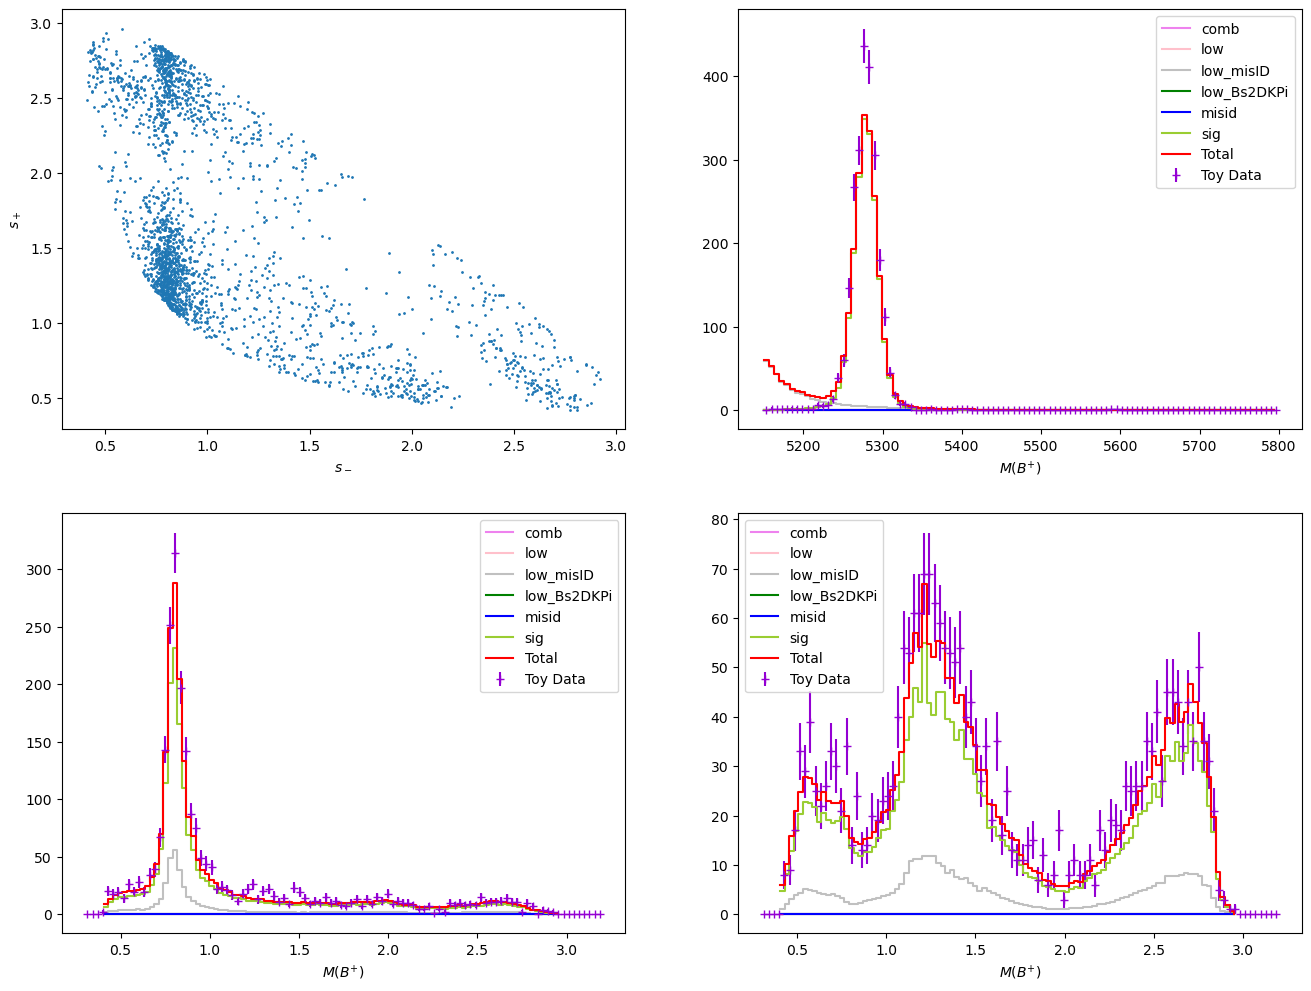

Mass builder finished in 35.39800763130188 seconds
Amplitude builder finished in 2.50649094581604 seconds
Fit finished in 13.453630208969116 seconds
Total time: 51.358128786087036 seconds


<Figure size 640x480 with 0 Axes>

In [ ]:
plot_each('b2dk_DD_p', prob_dk_dd_p)
plot_each('b2dk_DD_m', prob_dk_dd_m)

plot_each('b2dk_LL_p', prob_dk_ll_p)
plot_each('b2dk_LL_m', prob_dk_ll_m)
'''
plot_each('b2dpi_DD_p', prob_dpi_dd_p)
plot_each('b2dpi_DD_m', prob_dpi_dd_m)
plot_each('b2dpi_LL_p', prob_dpi_ll_p)
plot_each('b2dpi_LL_m', prob_dpi_ll_m)
'''

time4 = time.time()
print(f'Mass builder finished in {time2-time1} seconds')
print(f'Amplitude builder finished in {time3-time2} seconds')
print(f'Fit finished in {time4-time3} seconds')
print(f'Total time: {time4-time1} seconds')





(array([20., 10.,  5.,  3.,  2.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

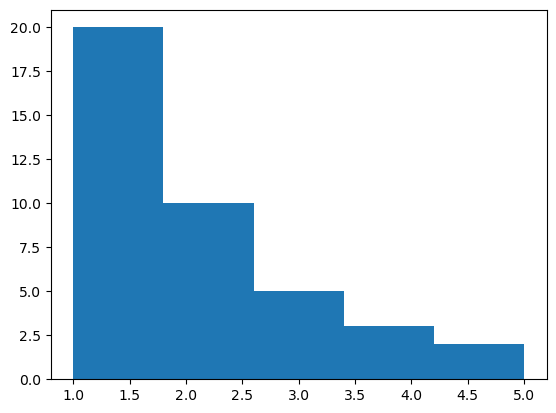

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
arr = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,4,4,4,5,5]
plt.hist(arr, bins=5)

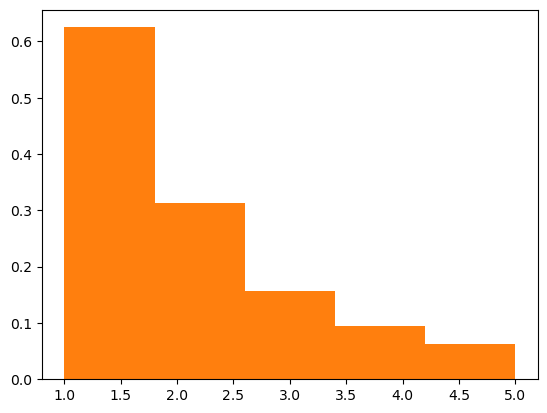

In [14]:
plt.hist(arr, bins=5, weights=np.ones_like(arr) * 1/40)
plt.hist(arr, bins=5, density=True)
#Get the x y and integrate the weights to see if it sums to 1
plt.show()

